# Part 1 - Data pre-processing

In [1]:
# Import LIBRARIES
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.parallel 
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable 


In [2]:
#DATASETS
movies = pd.read_csv("ml-1m/ml-1m/movies.dat", sep = "::", header = None, engine = "python", encoding = "latin-1")
users = pd.read_csv("ml-1m/ml-1m/users.dat", sep = "::", header = None, engine = "python", encoding = "latin-1")
ratings = pd.read_csv("ml-1m/ml-1m/ratings.dat", sep = "::", header = None, engine = "python", encoding = "latin-1")

In [3]:
# Prepare the training set and the testing set
training_set = pd.read_csv("ml-100k/ml-100k/u1.base", sep = "\t", header=  None)
training_set = np.array(training_set, dtype = "int")

test_set = pd.read_csv("ml-100k/ml-100k/u1.test", sep = "\t", header=  None)
test_set = np.array(test_set, dtype = "int")

# to obtain the number of users and number of films 
nb_users = int(max(max(training_set[:,0]),max(test_set[:,0])))
nb_movies = int(max(max(training_set[:,1]),max(test_set[:,1])))

# convert the data into an array X[u,i] with users u in row and movies i in column 
def convert(data):
    new_data = []
    for id_users in range(1,nb_users+1):
        id_movies = data[:,1][data[:,0] == id_users]
        id_ratings = data[:,2][data[:,0] == id_users]
        ratings = np.zeros(nb_movies)
        ratings[id_movies-1] = id_ratings
        new_data.append(list(ratings))
    return new_data

training_set = convert(training_set)
test_set = convert(test_set)

# Convert data to Torch tensors 
training_set = torch.FloatTensor(training_set) #expect everything to come in rows, that's why we have made a list of lists above.
test_set = torch.FloatTensor(test_set)

# Convert ratings to binary binary values 1 (Like) or 0 (Dislike):
training_set[training_set == 0] = -1
training_set[training_set == 1] = 0
training_set[training_set == 2] = 0
training_set[training_set >= 3] = 1

test_set[test_set == 0] = -1
test_set[test_set == 1] = 0
test_set[test_set == 2] = 0
test_set[test_set >= 3] = 1


# Part 2 - Model

In [6]:
#Create the architecture of the neural network (Probabilistic graphical model)
class RBM():
    def __init__(self, nv, nh):
        self.W = torch.randn(nh, nv)
        self.a = torch.rand(1, nh)  #batch and bias as it cannot be one-dimensional
        self.b = torch.rand(1, nv) 
    def sample_h(self,x):         
        #x user ratings x = mini_batch_size x nv
        wx = torch.mm(x, self.W.t()) # 1 row ( or mini_batch_size ) x nh columns
        activation = wx + self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation) #probability of hiddent given visible 
        return p_h_given_v, torch.bernoulli(p_h_given_v) #Bernuilli of probability.
    def sample_v(self,y):
        #y = mini_batch_size x nh  
        wy = torch.mm(y, self.W) # 1 row ( or mini_batch_size ) x nv columns
        activation = wy + self.b.expand_as(wy)
        p_h_given_h = torch.sigmoid(activation)  #probability of hiddent given visible 
        return p_h_given_h, torch.bernoulli(p_h_given_h) #Bernuilli of probability.
    def train(self, v0, vk, ph0, phk):
        self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(),phk)).t()
        self.b += torch.sum((v0 - vk),0)       #to maintain the dominance
        self.a += torch.sum((ph0 - phk ),0) 

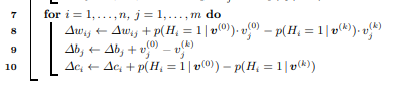

In [7]:
nv = len(training_set[0])   #could also be nb_movies
nh = 100
batch_size = 100

rbm = RBM(nv, nh)

# Training the rBM
nb_epoch = 10
for epoch in range(1, nb_epoch + 1): 
    training_loss = 0 
    s = 0. #observation counter
    for id_user in range(0, nb_users - batch_size, batch_size):
        vk = training_set[id_user:id_user+batch_size]
        v0 = training_set[id_user:id_user+batch_size]
        ph0, _ = rbm.sample_h(v0)
        for k in range(10):
            _,hk  = rbm.sample_h(vk)
            _,vk  = rbm.sample_v(hk)
            vk[v0 < 0] = v0[v0 < 0] #We do NOT want you to touch the -1, i.e. what users have not seen.
        phk, _ =rbm.sample_h(vk)
        rbm.train(v0,vk,ph0,phk)
        training_loss +=  torch.mean(torch.abs(v0[v0>0]-vk[v0>0]))
        s += 1.
    print("Epoch: " + str(epoch) +", Loss: " + str(training_loss/s)  )   

Epoch: 1, Loss: tensor(0.3234)
Epoch: 2, Loss: tensor(0.1356)
Epoch: 3, Loss: tensor(0.1502)
Epoch: 4, Loss: tensor(0.1487)
Epoch: 5, Loss: tensor(0.1569)
Epoch: 6, Loss: tensor(0.1448)
Epoch: 7, Loss: tensor(0.1513)
Epoch: 8, Loss: tensor(0.1490)
Epoch: 9, Loss: tensor(0.1510)
Epoch: 10, Loss: tensor(0.1452)


# TEST BM 

In [9]:
# Testing the MBR

testing_loss = 0 
s = 0. #observation counter
for id_user in range(nb_users):
    v = training_set[id_user:id_user+1] #we are still using information from the training set to fill in the gaps.
    vt = test_set[id_user:id_user+1]
    #for k in range(1): #We have trained it to take K steps and keep the predictions and then only use 1 so that the prediction is more likely to be good.
    if len(vt[vt>=0]) > 0:
        _,h  = rbm.sample_h(v)
        _,v  = rbm.sample_v(h)
        testing_loss +=  torch.mean(torch.abs(vt[vt>0]-v[vt>0]))
        s += 1.
        print("Testing Loss: " + str(training_loss/s)  )   


Testing Loss: tensor(1.3068)
Testing Loss: tensor(0.6534)
Testing Loss: tensor(0.4356)
Testing Loss: tensor(0.3267)
Testing Loss: tensor(0.2614)
Testing Loss: tensor(0.2178)
Testing Loss: tensor(0.1867)
Testing Loss: tensor(0.1634)
Testing Loss: tensor(0.1452)
Testing Loss: tensor(0.1307)
Testing Loss: tensor(0.1188)
Testing Loss: tensor(0.1089)
Testing Loss: tensor(0.1005)
Testing Loss: tensor(0.0933)
Testing Loss: tensor(0.0871)
Testing Loss: tensor(0.0817)
Testing Loss: tensor(0.0769)
Testing Loss: tensor(0.0726)
Testing Loss: tensor(0.0688)
Testing Loss: tensor(0.0653)
Testing Loss: tensor(0.0622)
Testing Loss: tensor(0.0594)
Testing Loss: tensor(0.0568)
Testing Loss: tensor(0.0545)
Testing Loss: tensor(0.0523)
Testing Loss: tensor(0.0503)
Testing Loss: tensor(0.0484)
Testing Loss: tensor(0.0467)
Testing Loss: tensor(0.0451)
Testing Loss: tensor(0.0436)
Testing Loss: tensor(0.0422)
Testing Loss: tensor(0.0408)
Testing Loss: tensor(0.0396)
Testing Loss: tensor(0.0384)
Testing Loss: 

# Measurements in the metrics of the model
 

In [7]:
############## WITH THE MSE OR MEAN SQUARED ERROR #################

#######TRAINING#############
nv = len(training_set[0])   #could also be nb_movies
nh = 100
batch_size = 100

rbm = RBM(nv, nh)

nb_epoch = 10
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(0, nb_users - batch_size, batch_size):
        vk = training_set[id_user:id_user+batch_size]
        v0 = training_set[id_user:id_user+batch_size]
        ph0,_ = rbm.sample_h(v0)
        for k in range(10):
            _,hk = rbm.sample_h(vk)
            _,vk = rbm.sample_v(hk)
            vk[v0<0] = v0[v0<0]
        phk,_ = rbm.sample_h(vk)
        rbm.train(v0, vk, ph0, phk)
        train_loss += np.sqrt(torch.mean((v0[v0>=0] - vk[v0>=0])**2)) # RMSE 
        s += 1.
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))
    
    ########################TESTING######################
    
test_loss = 0
s = 0.
for id_user in range(nb_users):
    v = training_set[id_user:id_user+1]
    vt = test_set[id_user:id_user+1]
    if len(vt[vt>=0]) > 0:
        _,h = rbm.sample_h(v)
        _,v = rbm.sample_v(h)
        test_loss += np.sqrt(torch.mean((vt[vt>=0] - v[vt>=0])**2)) # RMSE 
        s += 1.
print('test loss: '+str(test_loss/s))

epoch: 1 loss: tensor(0.5733)
epoch: 2 loss: tensor(0.4907)
epoch: 3 loss: tensor(0.4982)
epoch: 4 loss: tensor(0.5007)
epoch: 5 loss: tensor(0.4998)
epoch: 6 loss: tensor(0.4992)
epoch: 7 loss: tensor(0.4946)
epoch: 8 loss: tensor(0.4975)
epoch: 9 loss: tensor(0.4980)
epoch: 10 loss: tensor(0.4999)
test loss: tensor(0.4686)


Using the RMSE, our MBR would give an error around 0.46. But be careful, although it looks similar, don't confuse RMSE and average distance. An RMSE of 0.46 does not mean that the average distance between the prediction and the truth of the dataset is 0.46. In random mode we would end up with an RMSE of around 0.72. An error of 0.46 corresponds to 75% of successful prediction.
